# **Enhancing Customer Retention through Churn Prediction: A Machine Learning Approach to Classification Models**

In this project, we aim to find the likelihood of a customer leaving the organization,  
the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

`Null Hypothesis (H1)`
- "There is no difference in monthly charges `median` between customers who churn and those who do not churn."

`Alternative Hypothesis (H1')`
- "There is a difference in monthly charges `median` between customers who churn and those who do not churn."

`Null hypothesis(H2)`
- Customer churn depends on the period of time a customer has been with the company.

`Alternate hypothesis(H2')`
- Customer churn does not depend on the period of time the customer has been with the company.

`Business Questions`
1. ⁠What is the churn rate among customers?
2. ⁠Does the type of internet service influence customer churn?
3. Does the method of billing affect the likelihood of churn?
4. How do support services (tech support and online security) influence customer satisfaction and retention?
5. Does churn vary significantly across gender and age groups?

## **Importing necessary packages**

In [1]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.preprocessing import quantile_transform, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, log_loss

warnings. filterwarnings('ignore')

## **Data Collection** 

### Loading From Database

In [2]:
# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Creating a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connecting to the server
connection = pyodbc.connect(connection_string)

In [3]:
# Loading First dataset 3000 records
first_data = pd.read_sql_query(
    "SELECT * FROM dbo.LP2_Telco_churn_first_3000", connection)

# Saving the DataFrame to a CSV file
first_data.to_csv('data/LP2_Telco_churn_first_3000.csv', index=False)

first_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


### Loading from csv files

In [4]:
# Loading Second dataset 2000 records
second_data = pd.read_csv('data\LP2_Telco-churn-second-2000.csv')

# Data preview
second_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [5]:
# Loading Test data
test_data = pd.read_excel('data\Telco-churn-last-2000.xlsx')

# Data preview
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## **Data Information**

In [6]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [7]:
second_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


## **Data Cleaning**

In [9]:
#Checking for null values:
first_data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [10]:
# Imputing with the mode for categorical columns
categorical_columns = first_data.select_dtypes(
    include=['object', 'bool']).columns
for column in categorical_columns:
    if first_data[column].isnull().any():
        mode_value = first_data[column].mode()[0]
        first_data[column].fillna(mode_value, inplace=True)

In [11]:
# Convert True/False to 0/1 for SeniorCitizen in the first dataset to match the second dataset
# where true = 1 and false = 0
first_data['SeniorCitizen'] = first_data['SeniorCitizen'].apply(lambda x: 1 if x else 0)

# Convert booleans to 'Yes'/'No' for other columns in the first dataset
bool_columns = ['Partner', 'Dependents', 'Churn', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'PaperlessBilling']
for col in bool_columns:
    first_data[col] = first_data[col].map({True: 'Yes', False: 'No'}).fillna('No')

# Merging the first and second datasets
train_data = pd.concat([first_data, second_data], ignore_index=True)

In [12]:
# Converting 'TotalCharges' to numeric, 
train_data['TotalCharges'] = pd.to_numeric(
    train_data['TotalCharges'], errors='coerce')
test_data['TotalCharges'] = pd.to_numeric(
    test_data['TotalCharges'], errors='coerce')

# Filling missing values with the mean value of the column
mean_total_charges = train_data['TotalCharges'].mean()
train_data['TotalCharges'].fillna(mean_total_charges, inplace=True)
test_data['TotalCharges'].fillna(mean_total_charges, inplace=True)

In [13]:
#Dropping customerID from train_data
train_data.drop('customerID', axis=1, inplace=True)

In [14]:
# Saving the cleaned dataset to a CSV file
train_data.to_csv('data/train_data.csv', index=False)
test_data.to_csv('data/test_data.csv', index=False)

## **Exploritory Data Analysis (EDA)** 

In [15]:
train_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,5043,2,Male,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,5043.0,NaN,NaN,NaN,0.162403,0.368857,0.0,0.0,0.0,0.0,1.0
Partner,5043,2,No,2585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,5043,2,No,3482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,5043.0,NaN,NaN,NaN,32.576641,24.529807,0.0,9.0,29.0,56.0,72.0
PhoneService,5043,2,Yes,4554,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,5043,3,No,2693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,5043,3,Fiber optic,2248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,5043,3,No,3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,5043,3,No,2882,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Categorical Variables
- **Gender**: Nearly evenly split between males and females, with males slightly more prevalent. This suggests that gender-specific targeting may not be necessary for churn prevention strategies.

- **Senior Citizen**: Only about `16.2%` of the customers are senior citizens, which could be a niche market to explore for specific services or retention strategies.

- **Partner and Dependents**: A slight majority do not have a partner `51%` or dependents `69%`. This could indicate that single, independent individuals may be a significant demographic, possibly with different needs or usage patterns.

- **Phone Service**: Almost `90% `of customers have phone service, indicating a saturation of this service and possibly lower churn risk here compared to other services.

- **Multiple Lines**: The majority do not have multiple lines `53%`, but there's a significant portion that does, suggesting varied needs in communication services.

- **Internet Service**: Fiber optic is the most common type of internet service `45%`, followed by DSL. The popularity of fiber optic could indicate a demand for high-speed internet but may also highlight issues like higher costs or service satisfaction affecting churn.

- **Online Security, Online Backup, Device Protection, Tech Support**: Most customers do not subscribe to these services. This could point to potential areas for increasing service uptake and reducing churn by bundling these value-added services.

- **Streaming TV and Streaming Movies**: Slightly more customers have streaming movies than TV. This might suggest a preference or trend towards movie streaming, which could be leveraged in service packages.

- **Contract**: More than half of the customers are on a month-to-month contract, associated with higher churn rates. This is a critical area to focus on for retention strategies, possibly by encouraging longer contract terms.

- **Paperless Billing**: About `59%` use paperless billing, indicating a significant shift towards digital solutions.

- **Payment Method**: The most common payment method is electronic check `34%`, which could be correlated with churn, suggesting a review of payment options might influence customer satisfaction and retention.

### Numerical Variables
- **Tenure**: Ranges from `0` to `72` months, with an average of about `32.5` months. Longer tenure correlates strongly with lower churn, indicating the importance of focusing retention strategies on newer customers.

- **Monthly Charges**: Average monthly charges are about `$65.09`, but range widely from `$18.4` to `$118.65`, suggesting diverse service plans and possibly different price sensitivities among customers.

- **Total Charges**: Reflects the total amount spent by customers over time and varies widely, suggesting differing levels of customer engagement and investment in the services.


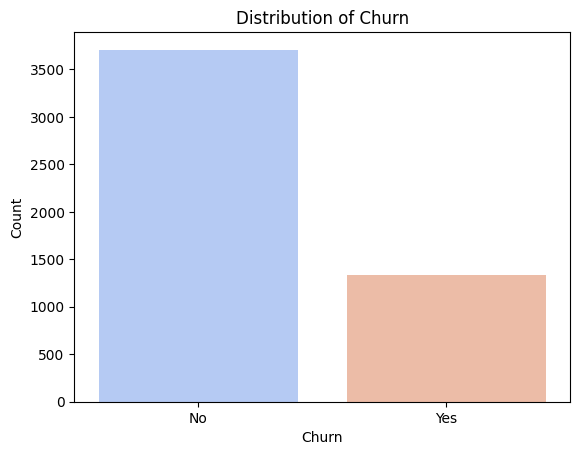

In [16]:
ax = sns.countplot(x='Churn', data=train_data, palette='coolwarm')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

### Churn
- The majority of the dataset consists of customers who have not churned `74%`, which is good but also highlights the importance of understanding why the remaining `26%` left.

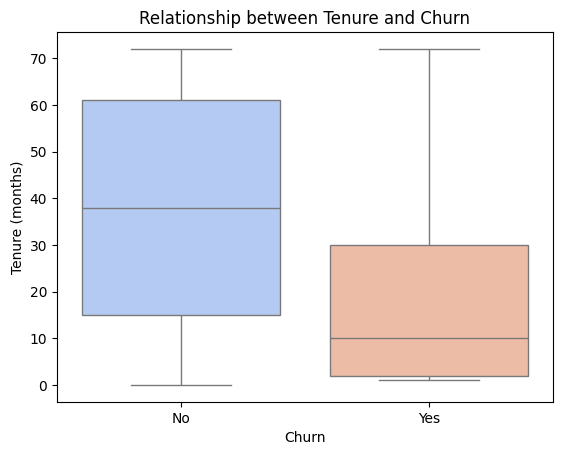

In [17]:
# Exploring the relationship between 'tenure' and 'Churn'
sns.boxplot(x='Churn', y='tenure', data=train_data, palette='coolwarm')
plt.title('Relationship between Tenure and Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.show()

- Customers who do not churn tend to have a higher tenure. This suggests that the longer a customer stays with the service, the less likely they are to churn.

- Customers who churn generally have a shorter tenure, indicating that churn is more frequent early in the customer relationship.

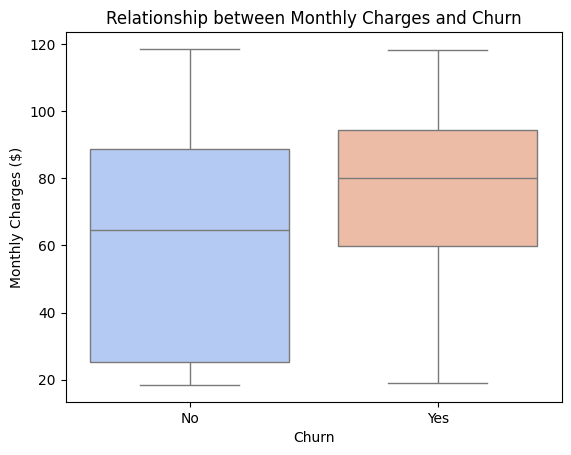

In [18]:
# Exploring the relationship between 'MonthlyCharges' and 'Churn'
sns.boxplot(x='Churn', y='MonthlyCharges', data=train_data, palette='coolwarm')
plt.title('Relationship between Monthly Charges and Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges ($)')
plt.show()

- The monthly charges are generally higher for customers who churn. This might indicate that higher costs could be a factor in the decision to leave the service.

- Customers who do not churn tend to have a wider range of monthly charges but with a lower median, suggesting they might be on more economical plans.

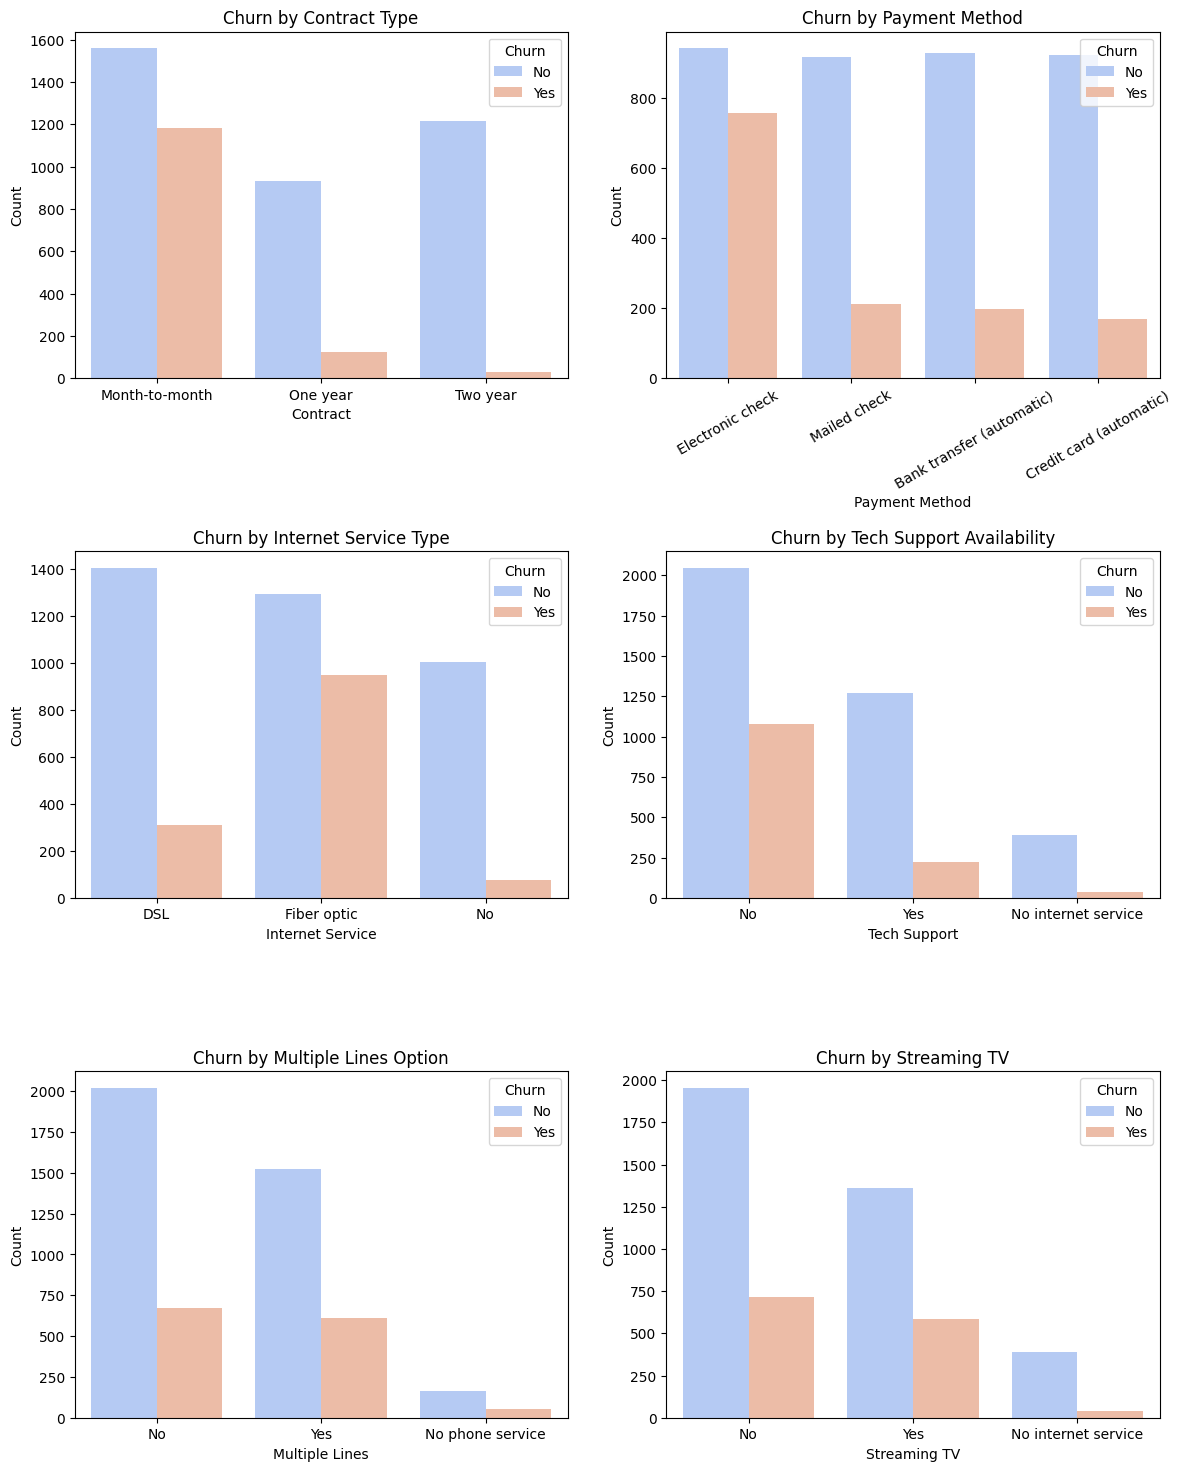

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
plt.subplots_adjust(hspace=0.5)

# Contract vs Churn
sns.countplot(ax=axes[0, 0], x='Contract', hue='Churn', data=train_data, palette='coolwarm')
axes[0, 0].set_title('Churn by Contract Type')
axes[0, 0].set_xlabel('Contract')
axes[0, 0].set_ylabel('Count')

# PaymentMethod vs Churn
sns.countplot(ax=axes[0, 1], x='PaymentMethod', hue='Churn', data=train_data, palette='coolwarm')
axes[0, 1].set_title('Churn by Payment Method')
axes[0, 1].set_xlabel('Payment Method')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=30)

# InternetService vs Churn
sns.countplot(ax=axes[1, 0], x='InternetService', hue='Churn', data=train_data, palette='coolwarm')
axes[1, 0].set_title('Churn by Internet Service Type')
axes[1, 0].set_xlabel('Internet Service')
axes[1, 0].set_ylabel('Count')

# TechSupport vs Churn
sns.countplot(ax=axes[1, 1], x='TechSupport', hue='Churn', data=train_data, palette='coolwarm')
axes[1, 1].set_title('Churn by Tech Support Availability')
axes[1, 1].set_xlabel('Tech Support')
axes[1, 1].set_ylabel('Count')

# MultipleLines vs Churn
sns.countplot(ax=axes[2, 0], x='MultipleLines', hue='Churn', data=train_data, palette='coolwarm')
axes[2, 0].set_title('Churn by Multiple Lines Option')
axes[2, 0].set_xlabel('Multiple Lines')
axes[2, 0].set_ylabel('Count')

# StreamingTV vs Churn
sns.countplot(ax=axes[2, 1], x='StreamingTV', hue='Churn', data=train_data, palette='coolwarm')
axes[2, 1].set_title('Churn by Streaming TV')
axes[2, 1].set_xlabel('Streaming TV')
axes[2, 1].set_ylabel('Count')

plt.show()

**Churn by Contract Type**
- Customers with month-to-month contracts are more likely to churn compared to those with longer-term contracts. This suggests that customers on short-term commitments feel less bound and possibly less satisfied, leading to higher churn rates.  

**Churn by Payment Method**
- The method of payment also seems to influence churn, with electronic checks showing a higher churn rate. This might be due to the demographics or the convenience factors associated with this payment method.  

**Churn by Internet Service Type**
- Customers with fiber optic services show a higher churn rate compared to those with DSL. This might reflect issues like cost or service expectations not being met with the higher-speed option.  

**Churn by Tech Support Availability**
- Having tech support appears to be a significant factor in retention, as customers without tech support show higher churn rates. This suggests that better customer support could improve customer retention.  

**Churn by Multiple Lines Option**
- There isn't a stark difference in churn rates based on whether customers have multiple lines or not, suggesting that simply having multiple lines isn't a deciding factor for churn.  

**Churn by Streaming TV**
- Customers who subscribe to streaming TV services have slightly higher churn rates, particularly those without the service. This might suggest that value-added services like streaming could either be a retention tool or a point of dissatisfaction if not handled correctly.  

## **Hypothesis Testing**

### Null Hypothesis (H1)
- "There is no difference in monthly charges `median` between customers who churn and those who do not churn."

### Alternative Hypothesis (H1')
- "There is a difference in monthly charges `median` between customers who churn and those who do not churn."

In [20]:
charges_churned = train_data[train_data['Churn'] == 'Yes']['MonthlyCharges']
charges_not_churned = train_data[train_data['Churn'] == 'No']['MonthlyCharges']

# Performing the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(charges_churned, charges_not_churned, alternative='two-sided')

print("U Statistic:", u_statistic)
print("P-value:", p_value)

U Statistic: 3100791.0
P-value: 1.2019873209608733e-42


In [21]:
# Alpha level of 0.05 
alpha = 0.05
if p_value < alpha:
    print("We Reject the Null Hypothesis(H1): There is a significant difference in monthly charges between churned and not churned customers.")
else:
    print("We Fail to Reject the Null Hypothesis(H1'): There is no significant difference in monthly charges between churned and not churned customers.")

We Reject the Null Hypothesis(H1): There is a significant difference in monthly charges between churned and not churned customers.


### Null hypothesis(H2)
- Customer churn depends on the period of time a customer has been with the company.

### Alternate hypothesis(H2')
- Customer churn does not depend on the period of time the customer has been with the company.

In [22]:
# Categorizing tenure into bins
"""
Short-term (0-12 months)
Mid-term (13-36 months)
Long-term (37+ months)
"""
bins = [0, 12, 36, train_data['tenure'].max() + 1]
labels = ['Short-term', 'Mid-term', 'Long-term']
train_data['tenure_group'] = pd.cut(train_data['tenure'], bins=bins, labels=labels, right=False)
test_data['tenure_group'] = pd.cut(test_data['tenure'], bins=bins, labels=labels, right=False)

In [23]:
# Creating contingency table
contingency_table = pd.crosstab(train_data['tenure_group'], train_data['Churn'])

# chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
 
chi2, p, dof, expected

(588.3575757336517,
 1.7369036845491502e-128,
 2,
 array([[1068.06880825,  384.93119175],
        [1021.75887369,  368.24112631],
        [1617.17231806,  582.82768194]]))

In [24]:
alpha = 0.05
if p < alpha:
    result = "We Reject the Null Hypothesis (H2): Customer churn depends on the period of time a customer has been with the company."
else:
    result = "We Fail to Reject the Null Hypothesis (H2'): Customer churn does not depend on the period of time a customer has been with the company."
result

'We Reject the Null Hypothesis (H2): Customer churn depends on the period of time a customer has been with the company.'

## **Business Questions**

### 1. ⁠What is the churn rate among customers?

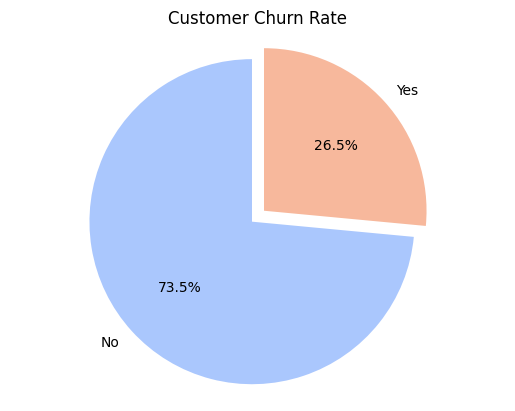

In [25]:
churn_rate = train_data['Churn'].value_counts(normalize=True)['Yes'] * 100

sns.set_palette('coolwarm')
churn_counts = train_data['Churn'].value_counts()

plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('coolwarm', 2), explode = (0.1, 0))
plt.title('Customer Churn Rate')
plt.axis('equal') 

plt.show()

- Nearly one out of every four `1/4` customers leaves the service.

### 2. ⁠Does the type of internet service influence customer churn?

In [26]:
internet_service_churn = pd.crosstab(train_data['InternetService'], train_data['Churn'], normalize='index') * 100

internet_service_churn

Churn,No,Yes
InternetService,,
DSL,81.982507,18.017493
Fiber optic,57.695730,42.304270
No,92.962963,7.037037


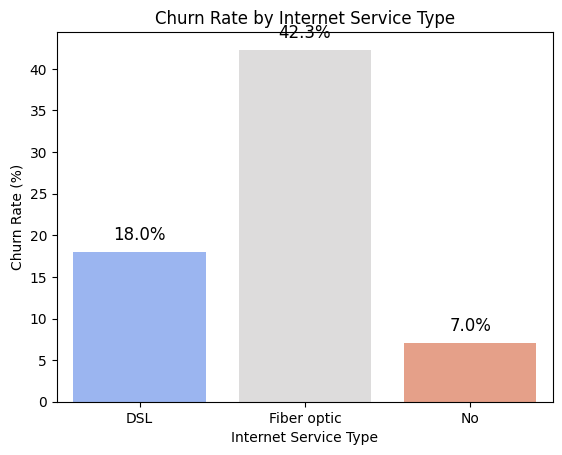

In [27]:
sns.barplot(x=internet_service_churn.index, y=internet_service_churn['Yes'], palette='coolwarm')
plt.title('Churn Rate by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Churn Rate (%)')
for index, value in enumerate(internet_service_churn['Yes']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=12)

plt.show()


- **Fiber optic service** customers are more likely to churn compared to customers using DSL or no internet service at all. This might suggest dissatisfaction with the fiber optic service or higher competition in the market for fiber optic users.

- **DSL service** users have a moderate churn rate, indicating relatively better retention compared to fiber optic service users.

- Customers **without internet service** show the lowest churn rate, which could indicate that these customers are more satisfied with other services provided or have fewer alternatives.

### 3. Does the method of billing affect the likelihood of churn?

In [28]:
payment_method_churn = pd.crosstab(
   train_data['PaymentMethod'],train_data['Churn'], normalize='index') * 100 

payment_method_churn

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),82.400000,17.600000
Credit card (automatic),84.587156,15.412844
Electronic check,55.411765,44.588235
Mailed check,81.205674,18.794326


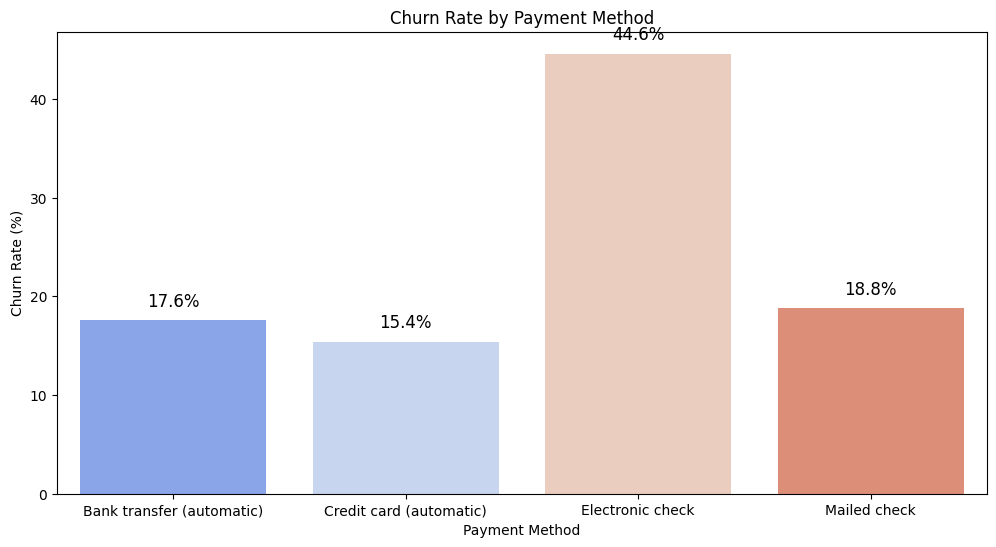

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(x=payment_method_churn.index,
            y=payment_method_churn['Yes'], palette='coolwarm')
plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate (%)')
for index, value in enumerate(payment_method_churn['Yes']):
    plt.text(index, value + 1, f'{value:.1f}%',
             ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=0)
plt.show()

- **Electronic check** customers are significantly more likely to churn compared to those using other payment methods. This high churn rate could indicate issues or dissatisfaction with the electronic check payment process. The lack of automation in this method could be a factor contributing to the higher churn rate.

- **Credit card (automatic)** and **Bank transfer (automatic)** users exhibit the lowest churn rate, suggesting higher satisfaction or convenience with this payment method.

- Customers using **Mailed check** have similar, moderate churn rates.


### 4. How do support services (tech support and online security) influence customer satisfaction and retention?

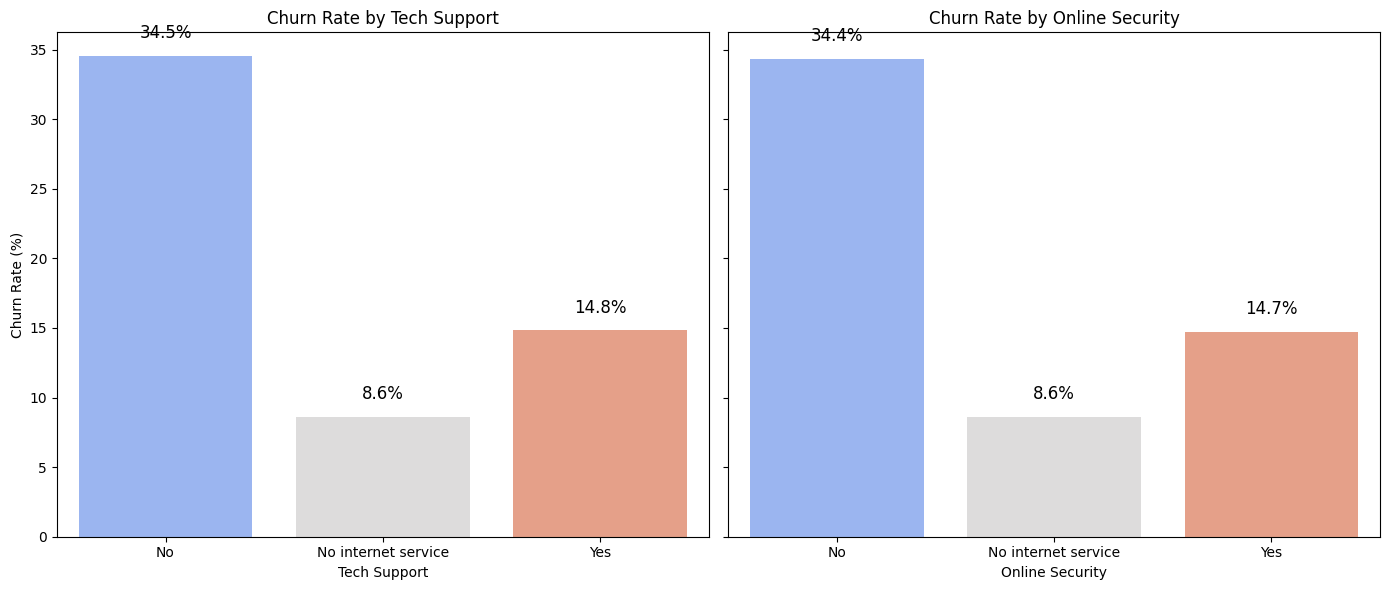

In [30]:
#Churn rates for customers with and without Tech Support
tech_support_churn = pd.crosstab(train_data['TechSupport'], train_data['Churn'], normalize='index') * 100

# Churn rates for customers with and without Online Security
online_security_churn = pd.crosstab(train_data['OnlineSecurity'], train_data['Churn'], normalize='index') * 100


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Tech Support
sns.barplot(ax=axes[0], x=tech_support_churn.index,
            y=tech_support_churn['Yes'], palette='coolwarm')
axes[0].set_title('Churn Rate by Tech Support')
axes[0].set_xlabel('Tech Support')
axes[0].set_ylabel('Churn Rate (%)')
for index, value in enumerate(tech_support_churn['Yes']):
    axes[0].text(index, value + 1, f'{value:.1f}%',
                 ha='center', va='bottom', fontsize=12)

# Plot for Online Security
sns.barplot(ax=axes[1], x=online_security_churn.index,
            y=online_security_churn['Yes'], palette='coolwarm')
axes[1].set_title('Churn Rate by Online Security')
axes[1].set_xlabel('Online Security')
axes[1].set_ylabel('')
for index, value in enumerate(online_security_churn['Yes']):
    axes[1].text(index, value + 1, f'{value:.1f}%',
                 ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

- **Support Services Influence**: Both tech support and online security services substantially reduce churn rates. Customers with these services are more likely to stay with the company, indicating higher satisfaction and retention.

- **Improving Retention**: Enhancing and promoting tech support and online security services could be effective strategies for improving customer retention and reducing churn.

### 5. Does churn vary significantly across gender and age groups?

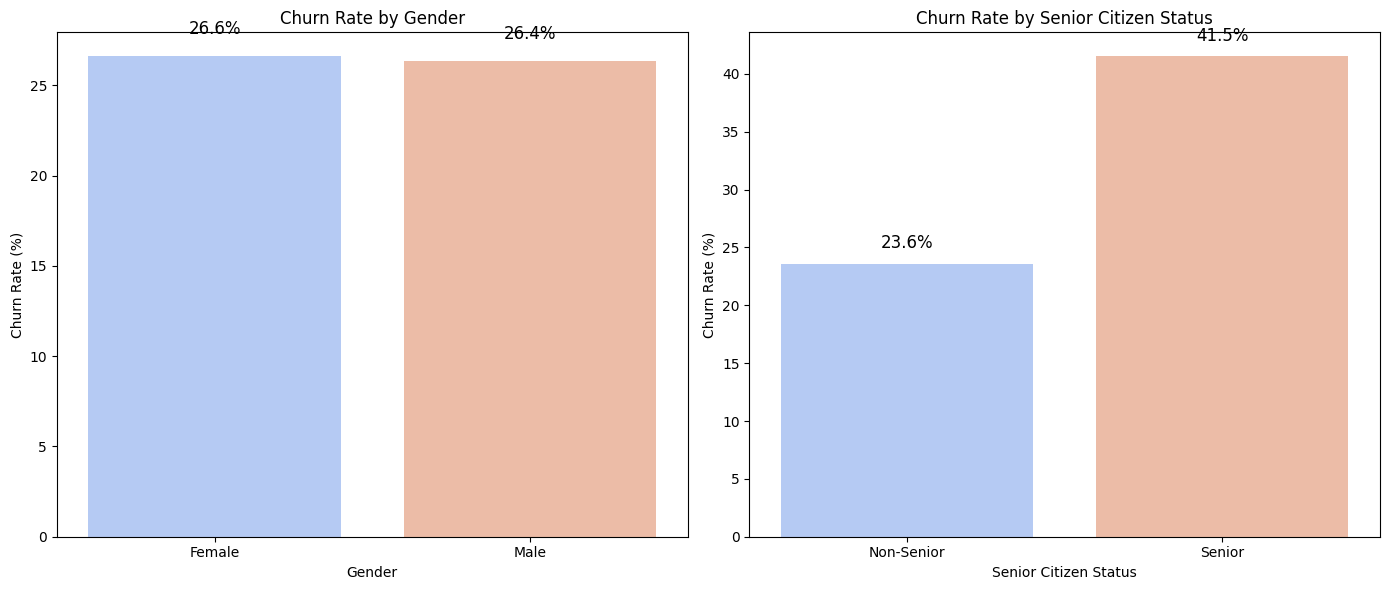

In [31]:
# Calculate churn rates for gender and senior citizen status
gender_churn = pd.crosstab(train_data['gender'], train_data['Churn'], normalize='index') * 100
senior_churn = pd.crosstab(train_data['SeniorCitizen'], train_data['Churn'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gender Churn Rate
sns.barplot(ax=axes[0], x=gender_churn.index,
            y=gender_churn['Yes'], palette='coolwarm')
axes[0].set_title('Churn Rate by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Churn Rate (%)')
for index, value in enumerate(gender_churn['Yes']):
    axes[0].text(index, value + 1, f'{value:.1f}%',
                 ha='center', va='bottom', fontsize=12)

# Senior Citizen Churn Rate
senior_labels = ['Non-Senior', 'Senior']
sns.barplot(ax=axes[1], x=senior_labels,
            y=senior_churn['Yes'], palette='coolwarm')
axes[1].set_title('Churn Rate by Senior Citizen Status')
axes[1].set_xlabel('Senior Citizen Status')
axes[1].set_ylabel('Churn Rate (%)')
for index, value in enumerate(senior_churn['Yes']):
    axes[1].text(index, value + 1, f'{value:.1f}%',
                 ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

- **Gender:** The churn rates between males and females are very similar, indicating that gender does not significantly affect churn.

- **Senior Citizen Status:** Senior citizens have a much higher churn rate compared to non-senior citizens, indicating that age group significantly influences churn.

## **Data Pre-Processing**

Up-Scaling the Minority Class

In [32]:
train_data.Churn.value_counts()

Churn
No     3707
Yes    1336
Name: count, dtype: int64

In [33]:
df_majority = train_data[train_data.Churn == 'No']
df_minority = train_data[train_data.Churn == 'Yes']

df_minority_upsampled = resample(df_minority,
                                 replace=True,               # sample with replacement
                                 n_samples=len(df_majority), # same length as majority class
                                 random_state=42)            # for reproducibility

train_data = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
train_data.Churn.value_counts()

Churn
No     3707
Yes    3707
Name: count, dtype: int64

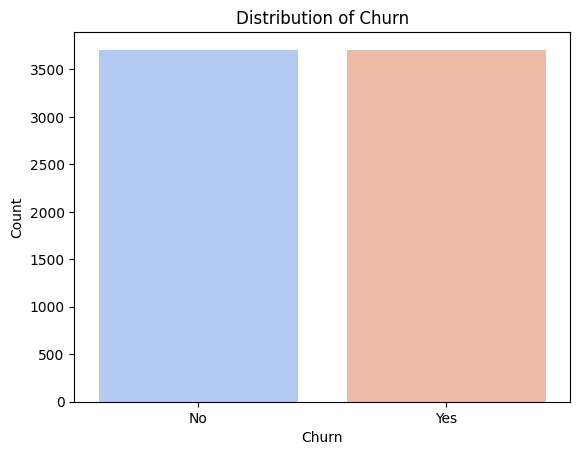

In [34]:
ax = sns.countplot(x='Churn', data=train_data, palette='coolwarm')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

Now we have a balanced distribution of the target class 

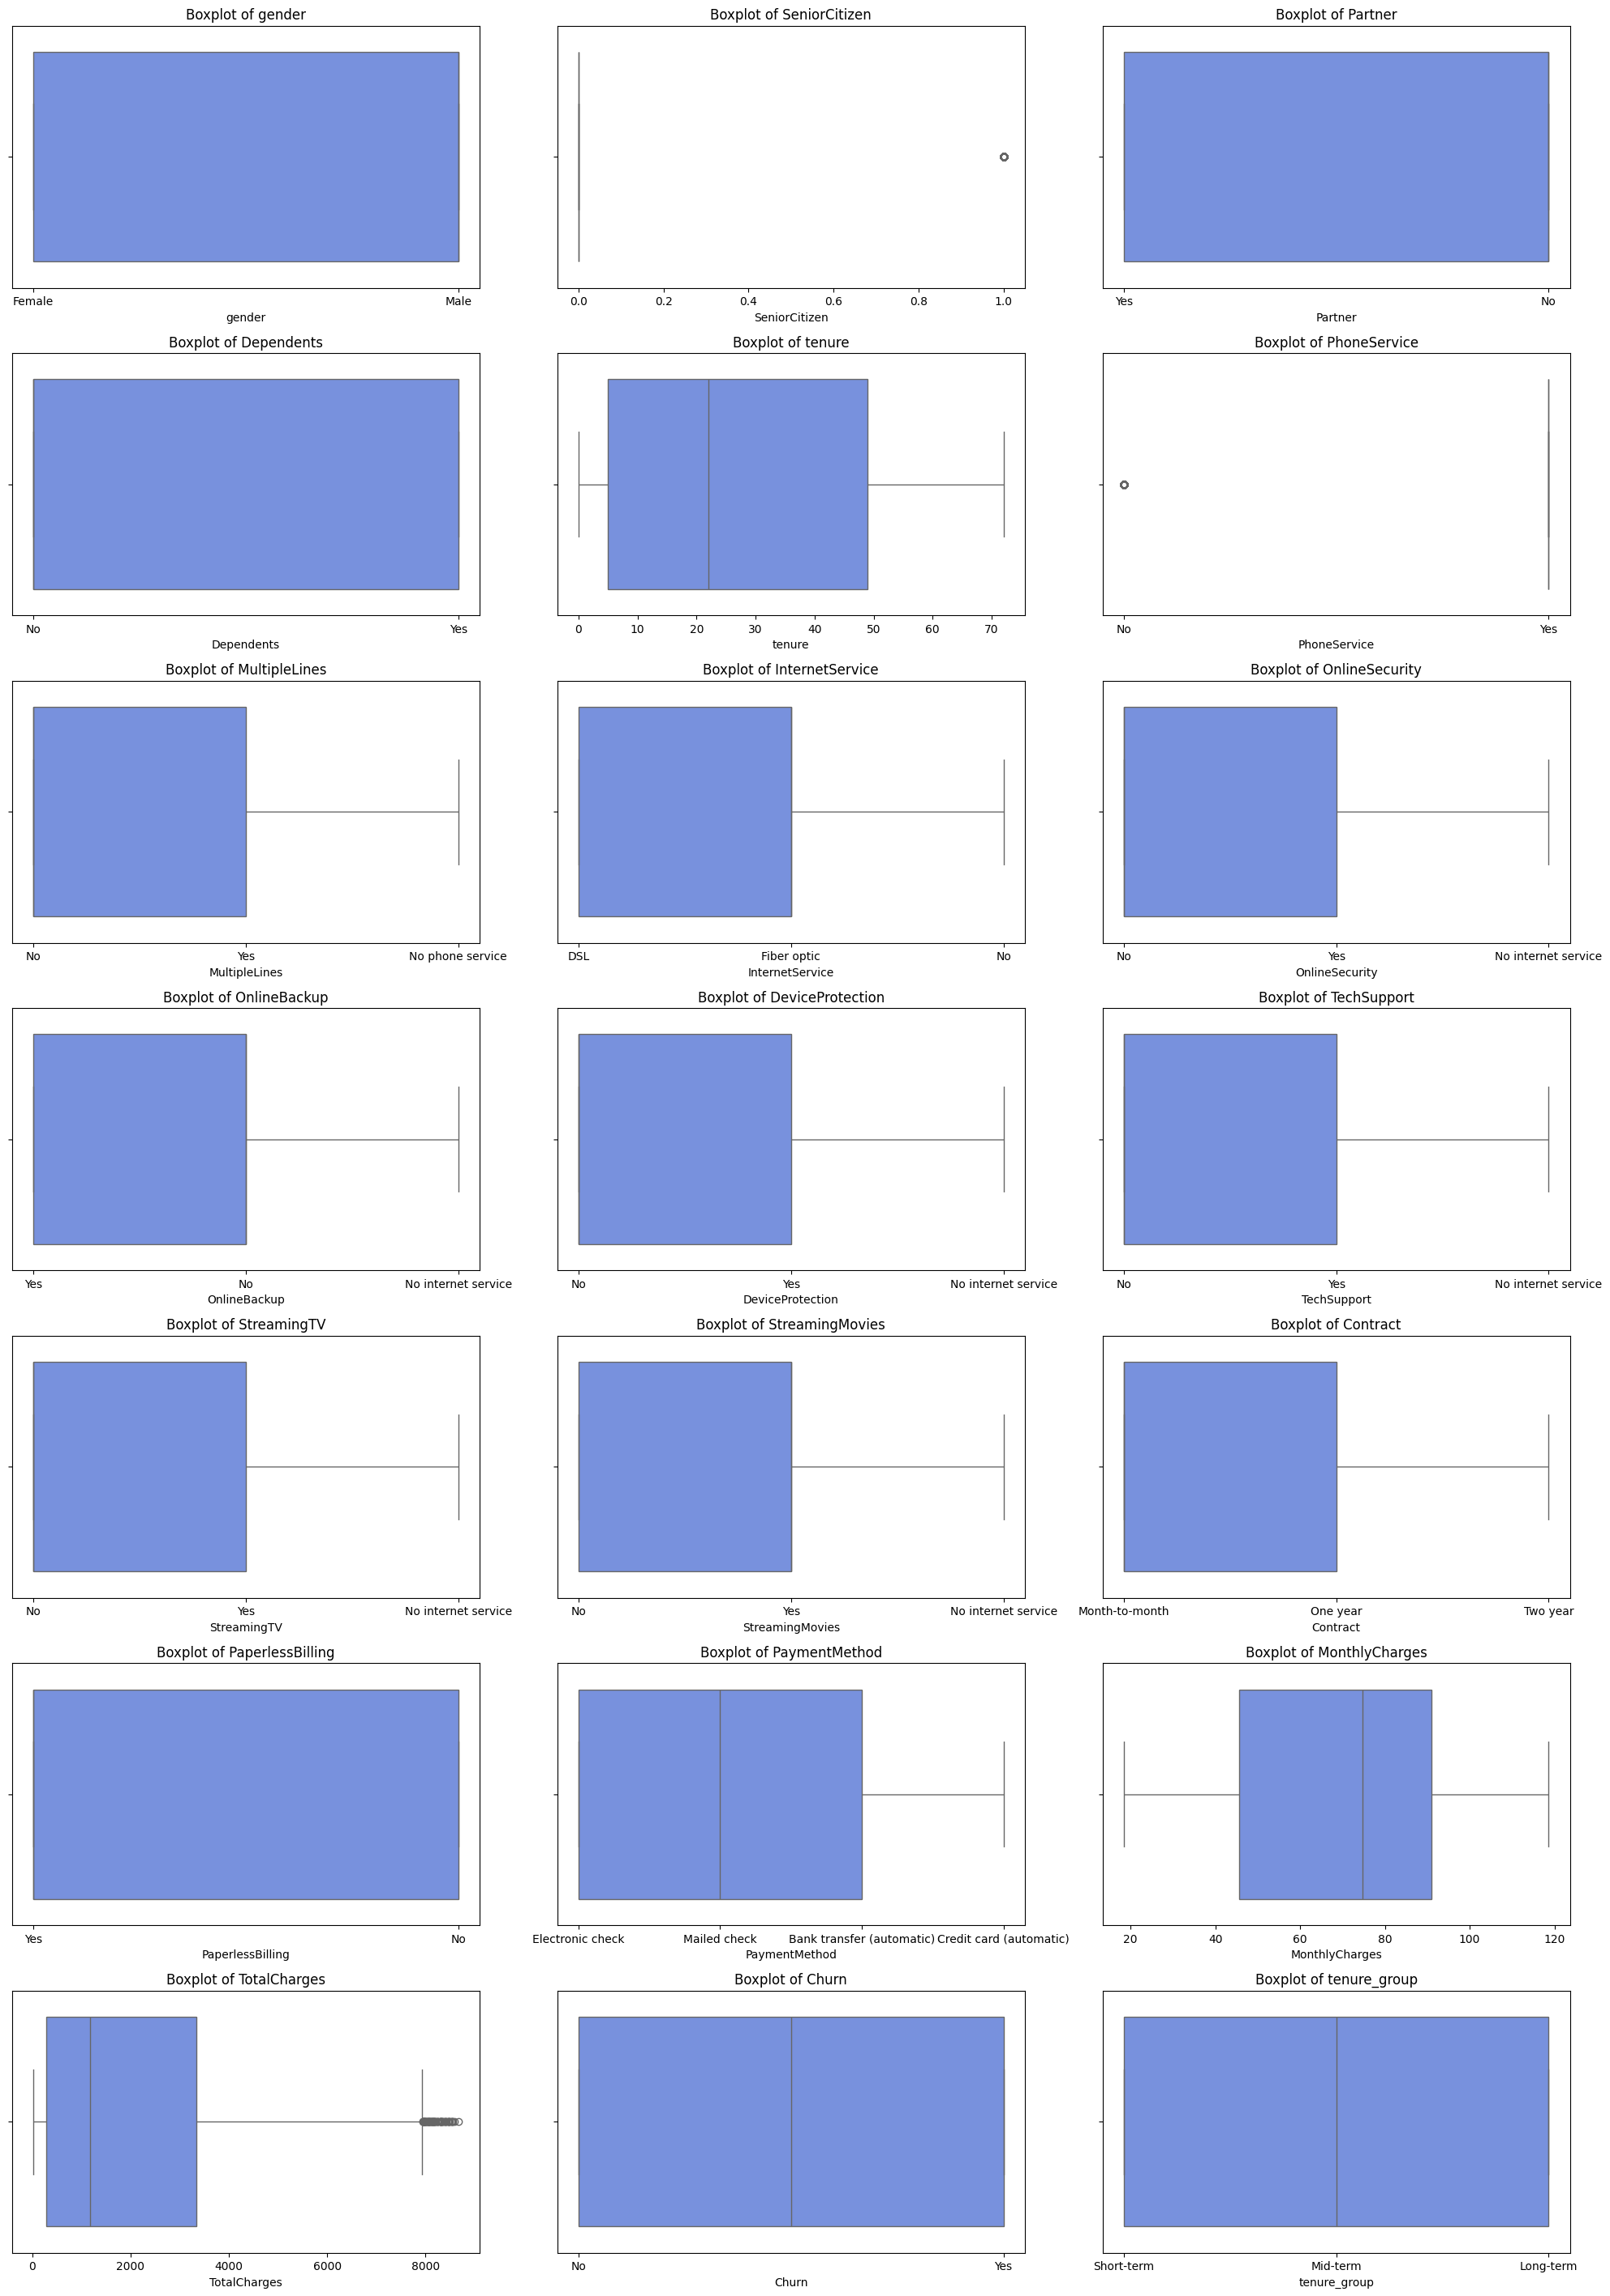

In [35]:
num_cols = len(train_data.columns)
fig, axes = plt.subplots(nrows=(num_cols // 3) + 1,
                         ncols=3, figsize=(20, 4 * ((num_cols // 3) + 1)))
axes = axes.flatten()
for i, column in enumerate(train_data.columns):
    sns.boxplot(x=train_data[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [36]:
# Identifying features and target variable
X = train_data.drop(columns=['Churn'])
y = train_data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [37]:
# Separating numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('SeniorCitizen')
categorical_cols = X.select_dtypes(include=['object']).columns

In [38]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('quantile_transform', FunctionTransformer(func=quantile_transform, validate=False))
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## **Modeling** 

In [39]:
# Defining the models
models = {
    'random_forest': RandomForestClassifier(),
    'logistic_regression': LogisticRegression(max_iter=1000),
    'svc': SVC(),
    'knn': KNeighborsClassifier(),
    'gradient_boosting': GradientBoostingClassifier(),
    'xgboost': XGBClassifier()
}

# Defining the parameter grid for each model
param_grid = {
    'random_forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'logistic_regression': {
        'model__C': [0.1, 1.0, 10.0],
        'model__solver': ['liblinear', 'lbfgs']
    },
    'svc': {
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'rbf']
    },
    'knn': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'gradient_boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'xgboost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0]
    }
}

In [40]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
# Initializing an empty dictionary to hold the GridSearchCV results for each model
grid_searches = {}

# Perform GridSearchCV for each model
for model_name in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', models[model_name])])
    grid_search = GridSearchCV(
        pipeline, param_grid[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    grid_searches[model_name] = grid_search

By employing 5-fold cross-validation, we ensure that our customer churn prediction model is robust, reliable, and capable of performing well on new, unseen data.  
- **Mitigates Overfitting**: By training and testing on different subsets, cross-validation helps ensure the model generalizes well.
- **Utilizes the Entire Dataset**: Every data point is used in training and validation, maximizing data use.
- **5 Folds**: Balances bias, variance, and computational efficiency, making it a practical and commonly used choice.

Model: random_forest
Accuracy: 0.8873904248145651
Precision: 0.8457831325301205
Recall: 0.9473684210526315
Log Loss: 0.31725796431427816
AUC: 0.9532957939114841


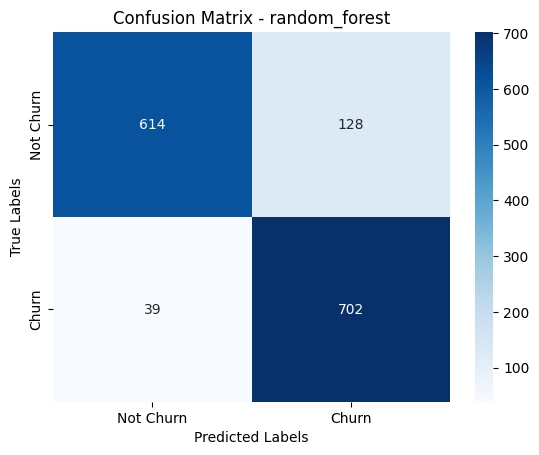

Model: logistic_regression
Accuracy: 0.7639919082939987
Precision: 0.7416563658838071
Recall: 0.8097165991902834
Log Loss: 0.4802878511586166
AUC: 0.8453190305226055


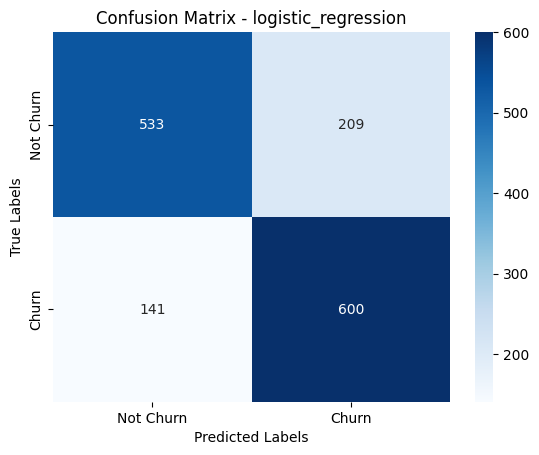

Model: svc
Accuracy: 0.8226567768037761
Precision: 0.7779069767441861
Recall: 0.902834008097166
Log Loss: None
AUC: None


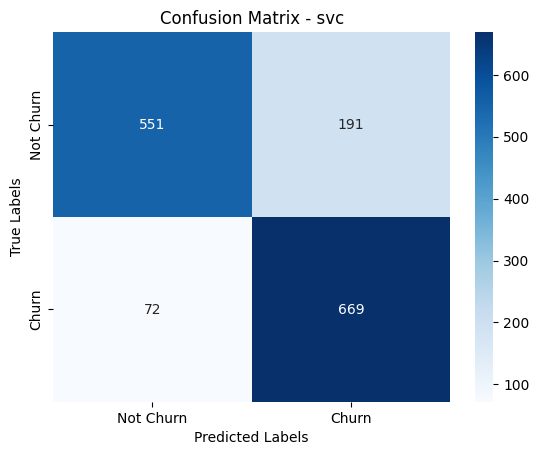

Model: knn
Accuracy: 0.8320971004720162
Precision: 0.7611464968152867
Recall: 0.9676113360323887
Log Loss: 1.4577409441372313
AUC: 0.9221975475699409


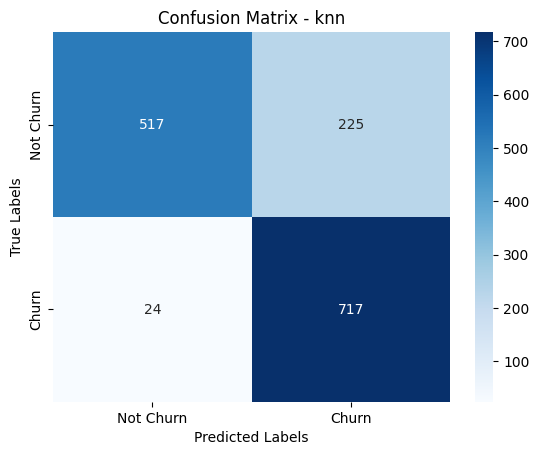

Model: gradient_boosting
Accuracy: 0.8165879973027647
Precision: 0.8025806451612904
Recall: 0.8394062078272605
Log Loss: 0.41443405769734104
AUC: 0.8864650741512708


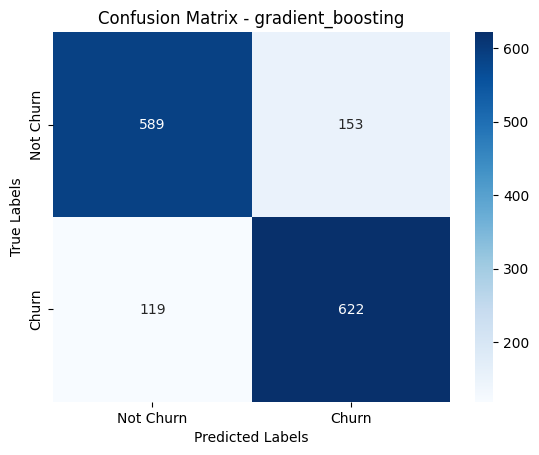

Model: xgboost
Accuracy: 0.8381658799730276
Precision: 0.8249027237354085
Recall: 0.8582995951417004
Log Loss: 0.39828539485701636
AUC: 0.9082075653575156


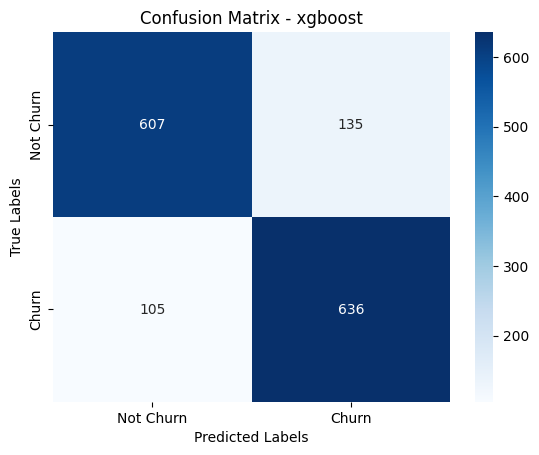

In [42]:
# Initializing a dictionary to hold evaluation metrics
evaluation_results = {}

# Evaluating each model on the validation set
for model_name, grid_search in grid_searches.items():
    y_pred = grid_search.predict(X_val)
    y_pred_proba = grid_search.predict_proba(X_val)[:, 1] if hasattr(
        grid_search.best_estimator_, "predict_proba") else None

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')  
    conf_matrix = confusion_matrix(y_val, y_pred)
    logloss = log_loss(
        y_val, y_pred_proba) if y_pred_proba is not None else None
    auc = roc_auc_score(
        y_val, y_pred_proba) if y_pred_proba is not None else None

    evaluation_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix,
        'log_loss': logloss,
        'auc': auc
    }

# Print evaluation metrics and plot confusion matrix
for model_name, metrics in evaluation_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"Log Loss: {metrics['log_loss']}")
    print(f"AUC: {metrics['auc']}")

    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt="d", cmap='Blues',
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

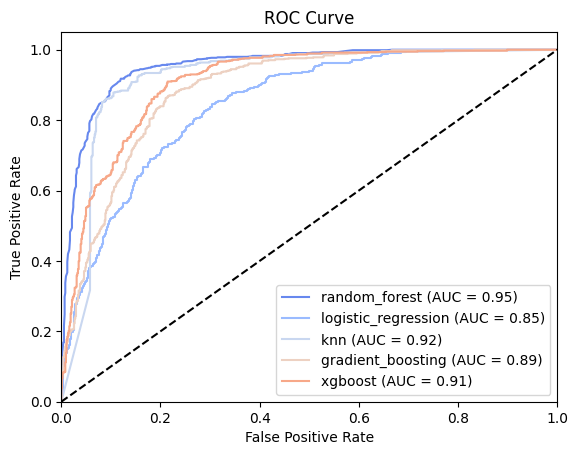

In [43]:
# ROC curve for each model
for model_name, grid_search in grid_searches.items():
    if evaluation_results[model_name]['auc'] is not None:
        fpr, tpr, _ = roc_curve(y_val, grid_search.predict_proba(X_val)[:, 1])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {
                 evaluation_results[model_name]['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()